# Inverse covariance matrices

In other notebooks we see that the emulator does well in predicting covariance matrices. However, parameter constraints are largely driven by $\chi^2$, which depends on the precision matrix or inverse covariance matrix $C^{-1}$. Since precision matrices are by definition invertable, we should be able to emulate them without issue. Here we will attempt that.

In [1]:
import numpy as np
from scipy import stats
import covariance_emulator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rc("font", size=14, family="serif")
#plt.rc("text", usetex=True)

In [3]:
#Read in the domain locations, or locations in parameter space
parameters = np.loadtxt("cosmo_parameters.txt")[:, :]
#covs = np.load("tomo0_sub_covs.npy")
covs = np.load("gaussian_tomo_sub_covs.npy")
#covs = np.load("gaussian_full_covs.npy")
#Take only a subset
covs = covs[:, 0:200, 0:200]
icovs = np.array([np.linalg.inv(covs[i]) for i in range(len(covs))])

In [4]:
#View the correlation matrix of the first
def corr_from_cov(cov):
    D = np.diag(np.sqrt(cov.diagonal()))
    Di = np.linalg.inv(D)
    return np.dot(Di, np.dot(cov, Di))

def view_corr(cov, lncov=False):
    R = corr_from_cov(cov)
    fig, ax = plt.subplots()
    if lncov:
        R = np.log(np.fabs(cov))
    im = ax.imshow(R, interpolation="nearest", origin="lower")
    plt.colorbar(im)
    return

In [5]:
#Split off the last covariance matrix
test_cov = covs[-1]
test_icov = icovs[-1]
test_parameters = parameters[-1]
covs = covs[:-1]
icovs = icovs[:-1]
parameters = parameters[:-1]

In [6]:
#Create an emulator
Emu = covariance_emulator.CovEmu(parameters, icovs, NPC_D=6, NPC_L=6)
iCpredicted = Emu.predict(test_parameters)

In [18]:
#Given a covariance matrix, make realizations of the noise, and then find the optimal kernel set up
def best_kernel_for_C(C, N_samples=1000):
    dof = len(C)
    means = np.zeros(dof)
    chi2s = np.zeros(N_samples)
    noise_realizations = np.array([np.random.multivariate_normal(means, C) for i in range(N_samples)])
    import george.kernels as kernels
    kerns = [kernels.ExpSquaredKernel, 
             kernels.Matern52Kernel, 
             kernels.Matern32Kernel]
    names = ["Exp2", "Mat52", "Mat32"]
    Npars = len(parameters[0])
    metric_guess = np.std(parameters, 0)
    #Loop over kernel combinations and compute the chi2 shift
    best_shift = 1e99
    best_kernels = None
    for nameD, kd in zip(names, kerns):
        kernel_D = 1.*kd(metric=metric_guess, ndim=Npars)
        for nameL, kl in zip(names, kerns):
            kernel_L = 1.*kl(metric=metric_guess, ndim=Npars)
            Emu = covariance_emulator.CovEmu(parameters, icovs, NPC_D=6, NPC_L=6, 
                                             kernel_D = kernel_D, kernel_lp = kernel_L)
            shift = 0
            try:
                iCpredicted = Emu.predict(test_parameters)
            except np.linalg.LinAlgError:
                shift = 1e99
            else:
                for i in range(N_samples):
                    chi2s[i] = np.dot(noise_realizations[i], np.dot(iCpredicted, noise_realizations[i]))
                    shift = np.mean(chi2s) - dof
            if shift < best_shift and shift > 0:
                best_shift = shift
                best_name = "%s %s"%(nameD, nameL)
                best_kernels = [kernel_D, kernel_L]
            print("%s %s: %e / %d"%(nameD, nameL, shift, dof))
    print("Best combination: %s"%best_name)
    print("\tshift/dof = %e / %d"%(best_shift, dof))
    return best_kernels

In [19]:
best_kernels = best_kernel_for_C(test_cov)

Exp2 Exp2: 1.778660e+00 / 200
Exp2 Mat52: 1.280511e+00 / 200
Exp2 Mat32: 4.711324e+00 / 200
Mat52 Exp2: 1.753457e+00 / 200
Mat52 Mat52: 1.245693e+00 / 200
Mat52 Mat32: 4.711523e+00 / 200
Mat32 Exp2: -4.840180e-02 / 200
Mat32 Mat52: -5.485035e-01 / 200
Mat32 Mat32: 2.872079e+00 / 200
Best combination: Mat52 Mat52
	shift/dof = 1.245693e+00 / 200


In [30]:
kernel_D, kernel_L = best_kernels
Emu = covariance_emulator.CovEmu(parameters, icovs, NPC_D=6, NPC_L=6,
                                 kernel_D = kernel_D, kernel_lp = kernel_L)
iCpredicted = Emu.predict(test_parameters)

## Assessing the emulator performance

One of the best ways to assess the performance of the emulator is to directly compare the true covariance to the emulated covariance. In the next cell, I will draw realizations of the noise from the true covariance, and compute $\chi^2$ values of these noises compared agains the emulated covariance. Then, by checking this against the expected distribution, we can see the performance of the emulator.

In [10]:
#Define a function where we input two covariances, and get back out a list of chi2s
def get_chi2s_between_C_and_iC(C1, iC2, N_samples=10000):
    means = np.zeros(len(C1))
    chi2s = np.zeros(N_samples)
    for i in range(N_samples):
        x = np.random.multivariate_normal(means, C1)
        chi2s[i] = np.dot(x, np.dot(iC2, x))
    return chi2s

dof = len(test_cov)
x = np.linspace(dof*.7, dof*1.4, 1000)

Text(0.5,1,'$C_{\\rm true}$ vs $C_{\\rm true}^{-1}$')

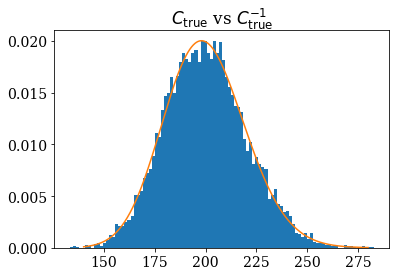

In [11]:
chi2s = get_chi2s_between_C_and_iC(test_cov, test_icov)
plt.hist(chi2s, density=True, bins=100)
plt.plot(x, stats.chi2.pdf(x, dof))
plt.title(r"$C_{\rm true}$ vs $C_{\rm true}^{-1}$")

Chi2/dof shift = 27.69 / 200


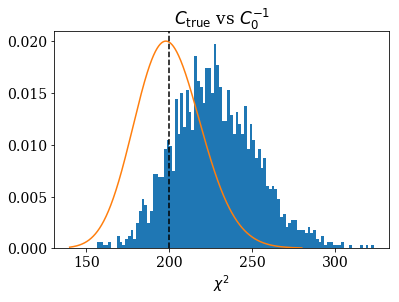

In [14]:
chi2s = get_chi2s_between_C_and_iC(test_cov, icovs[0], 2000)
plt.hist(chi2s, density=True, bins=100)
plt.plot(x, stats.chi2.pdf(x, dof))
plt.title(r"$C_{\rm true}$ vs $C_{\rm 0}^{-1}$")
plt.xlabel(r"$\chi^2$")
plt.axvline(dof, color="k", ls="--")
ax = plt.gca()
print("Chi2/dof shift = %.2f / %d"%(np.mean(chi2s) - dof, dof))

In [31]:
chi2s = get_chi2s_between_C_and_iC(test_cov, iCpredicted, 10000)

Chi2/dof shift = 1.65 / 200


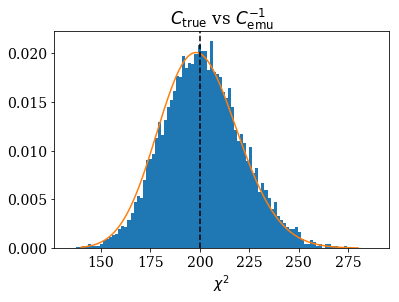

In [32]:
plt.hist(chi2s, density=True, bins=100)
plt.plot(x, stats.chi2.pdf(x, dof))
plt.title(r"$C_{\rm true}$ vs $C_{\rm emu}^{-1}$")
plt.xlabel(r"$\chi^2$")
plt.axvline(dof, color="k", ls="--")
ax = plt.gca()
print("Chi2/dof shift = %.2f / %d"%(np.mean(chi2s) - dof, dof))
#plt.savefig("chi2_realizations.png", dpi=300, bbox_inches="tight")

In [33]:
print chi2s[:4]
print np.mean(chi2s)
print np.max(chi2s), np.min(chi2s)

[210.22836503 228.33780273 216.00859622 209.51622004]
201.65367376315564
288.0116009712819 134.2177466950104
